# Key Detection

1. Loading the Audio File:

We start by loading an audio file using Librosa’s load function. This function returns the audio waveform (y) and the sample rate (sr) of the audio file. The sample rate represents the number of samples per second in the audio.

2. Chroma Feature Extraction:

The librosa.feature.chroma_stft function is used to compute the Chroma Short-Time Fourier Transform (chromagram) of the audio. The chromagram is a representation of the twelve different pitch classes in music.

3. Calculating Mean Chroma Feature:

We calculate the mean chroma feature across time by taking the average along axis=1 of the chromagram matrix. This results in a single chroma vector that summarizes the pitch content of the audio.

4. Mapping Chroma Features to Keys:

In music theory, there are twelve possible keys, each associated with a specific set of notes. We define chroma_to_key, a list that maps the twelve chroma features to their corresponding keys.

5. Detecting the Key:

To detect the key, we find the index of the maximum value in the mean chroma vector using np.argmax. This index corresponds to the estimated key, which we obtain from chroma_to_key. Finally, we print the detected key.

In [10]:
import librosa
import numpy as np
def findKey(audio_file_path):
        # Load the audio file
    y, sr = librosa.load(audio_file_path)
        
        # Compute the Chroma Short-Time Fourier Transform (chroma_stft)
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
        
        # Calculate the mean chroma feature across time
    mean_chroma = np.mean(chromagram, axis=1)
        
        # Define the mapping of chroma features to keys
    chroma_to_key = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
        
        # Find the key by selecting the maximum chroma feature
    estimated_key_index = np.argmax(mean_chroma)
    estimated_key = chroma_to_key[estimated_key_index]
    return estimated_key
# Print the detected key
print("Detected Key:", findKey('../audio/audio_sample.mp3'))

Detected Key: A


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
#Repo
#https://github.com/jackmcarthur/musical-key-finder/tree/master

# class that uses the librosa library to analyze the key that an mp3 is in
# arguments:
#     waveform: an mp3 file loaded by librosa, ideally separated out from any percussive sources
#     sr: sampling rate of the mp3, which can be obtained when the file is read with librosa
#     tstart and tend: the range in seconds of the file to be analyzed; default to the beginning and end of file if not specified
class Tonal_Fragment(object):
    def __init__(self, waveform, sr, tstart=None, tend=None):
        self.waveform = waveform
        self.sr = sr
        self.tstart = tstart
        self.tend = tend
        
        if self.tstart is not None:
            self.tstart = librosa.time_to_samples(self.tstart, sr=self.sr)
        if self.tend is not None:
            self.tend = librosa.time_to_samples(self.tend, sr=self.sr)
        self.y_segment = self.waveform[self.tstart:self.tend]
        self.chromograph = librosa.feature.chroma_cqt(y=self.y_segment, sr=self.sr, bins_per_octave=24)
        
        # chroma_vals is the amount of each pitch class present in this time interval
        self.chroma_vals = []
        for i in range(12):
            self.chroma_vals.append(np.sum(self.chromograph[i]))
        pitches = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
        # dictionary relating pitch names to the associated intensity in the song
        self.keyfreqs = {pitches[i]: self.chroma_vals[i] for i in range(12)} 
        
        keys = [pitches[i] + ' major' for i in range(12)] + [pitches[i] + ' minor' for i in range(12)]

        # use of the Krumhansl-Schmuckler key-finding algorithm, which compares the chroma
        # data above to typical profiles of major and minor keys:
        maj_profile = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
        min_profile = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

        # finds correlations between the amount of each pitch class in the time interval and the above profiles,
        # starting on each of the 12 pitches. then creates dict of the musical keys (major/minor) to the correlation
        self.min_key_corrs = []
        self.maj_key_corrs = []
        for i in range(12):
            key_test = [self.keyfreqs.get(pitches[(i + m)%12]) for m in range(12)]
            # correlation coefficients (strengths of correlation for each key)
            self.maj_key_corrs.append(round(np.corrcoef(maj_profile, key_test)[1,0], 3))
            self.min_key_corrs.append(round(np.corrcoef(min_profile, key_test)[1,0], 3))

        # names of all major and minor keys
        self.key_dict = {**{keys[i]: self.maj_key_corrs[i] for i in range(12)}, 
                         **{keys[i+12]: self.min_key_corrs[i] for i in range(12)}}
        
        # this attribute represents the key determined by the algorithm
        self.key = max(self.key_dict, key=self.key_dict.get)
        self.bestcorr = max(self.key_dict.values())
        
        # this attribute represents the second-best key determined by the algorithm,
        # if the correlation is close to that of the actual key determined
        self.altkey = None
        self.altbestcorr = None

        for key, corr in self.key_dict.items():
            if corr > self.bestcorr*0.9 and corr != self.bestcorr:
                self.altkey = key
                self.altbestcorr = corr
                
    # prints the relative prominence of each pitch class            
    def print_chroma(self):
        self.chroma_max = max(self.chroma_vals)
        for key, chrom in self.keyfreqs.items():
            print(key, '\t', f'{chrom/self.chroma_max:5.3f}')
                
    # prints the correlation coefficients associated with each major/minor key
    def corr_table(self):
        for key, corr in self.key_dict.items():
            print(key, '\t', f'{corr:6.3f}')
    
    # printout of the key determined by the algorithm; if another key is close, that key is mentioned
    def print_key(self):
        print("likely key: ", max(self.key_dict, key=self.key_dict.get), ", correlation: ", self.bestcorr, sep='')
        if self.altkey is not None:
                print("also possible: ", self.altkey, ", correlation: ", self.altbestcorr, sep='')
    
    # prints a chromagram of the file, showing the intensity of each pitch class over time
    def chromagram(self, title=None):
        C = librosa.feature.chroma_cqt(y=self.waveform, sr=sr, bins_per_octave=24)
        plt.figure(figsize=(12,4))
        librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
        if title is None:
            plt.title('Chromagram')
        else:
            plt.title(title)
        plt.colorbar()
        plt.tight_layout()
        plt.show()

# The Main Ingredient – Magic Shoes / Spinning Around

- Label:	RCA Victor – 74-0456
- Format:	Vinyl, 7", 45 RPM
- Country:	Canada
- Released:	1971
- Genre:	Funk / Soul
- Style:	Soul
- Key: A♯/B♭ key and a major mode
- BPM: 100

In [17]:
print("Detected Key:", findKey('../audio/song.mp3'))

Detected Key: D


In [18]:
import numpy as np
import scipy.linalg
from scipy.stats import zscore

from typing import List


class KeyEstimator:

    # adapted from:
    # https://gist.github.com/bmcfee/1f66825cef2eb34c839b42dddbad49fd

    major = np.asarray(
        [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
    )
    minor = np.asarray(
        [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]
    )

    def __post_init__(self):
        self.major = zscore(self.major)
        self.major_norm = scipy.linalg.norm(self.major)
        self.major = scipy.linalg.circulant(self.major)

        self.minor = zscore(self.minor)
        self.minor_norm = scipy.linalg.norm(self.minor)
        self.minor = scipy.linalg.circulant(self.minor)

    def __call__(self, x: np.array) -> List[np.array]:

        x = zscore(x)
        x_norm = scipy.linalg.norm(x)

        coeffs_major = self.major.T.dot(x) / self.major_norm / x_norm
        coeffs_minor = self.minor.T.dot(x) / self.minor_norm / x_norm

        return coeffs_major, coeffs_minor

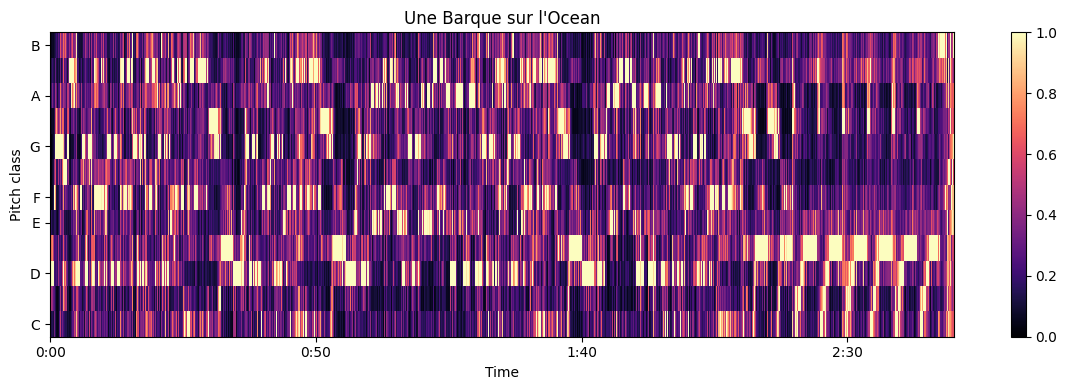

C 	 0.532
C# 	 0.507
D 	 1.000
D# 	 0.542
E 	 0.518
F 	 0.818
F# 	 0.687
G 	 0.866
G# 	 0.538
A 	 0.700
A# 	 0.724
B 	 0.569
likely key: D minor, correlation: 0.776
C major 	  0.159
C# major 	 -0.339
D major 	  0.613
D# major 	  0.019
E major 	 -0.585
F major 	  0.408
F# major 	 -0.290
G major 	  0.486
G# major 	 -0.429
A major 	 -0.093
A# major 	  0.531
B major 	 -0.480
C minor 	 -0.082
C# minor 	 -0.685
D minor 	  0.776
D# minor 	 -0.166
E minor 	 -0.084
F minor 	 -0.097
F# minor 	  0.030
G minor 	  0.683
G# minor 	 -0.559
A minor 	 -0.026
A# minor 	 -0.081
B minor 	  0.290
likely key: A# major, correlation: 0.632
also possible: F minor, correlation: 0.6


In [19]:
audio_path = '../audio/song.mp3'
y, sr = librosa.load(audio_path)
y_harmonic, y_percussive = librosa.effects.hpss(y)

unebarque = Tonal_Fragment(y_harmonic, sr)
unebarque.chromagram("Une Barque sur l\'Ocean")
unebarque_fsharp_min = Tonal_Fragment(y_harmonic, sr, tend=22)
unebarque_fsharp_min.print_chroma()
unebarque_fsharp_maj = Tonal_Fragment(y_harmonic, sr, tend=22)
unebarque_fsharp_maj.print_key()
unebarque_fsharp_min.corr_table()
unebarque_e_min = Tonal_Fragment(y_harmonic, sr, tstart=22, tend=33)
unebarque_e_min.print_key()